# Deep Learning

## Weather Classification

### Importing Libraries

In [ ]:
import os
import shutil
import random
from glob import glob
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

import json
import cv2
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, roc_curve, auc,
    roc_auc_score
)

from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader, random_split



### Loading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.listdir('/content/drive/MyDrive/dataset')

['snow',
 'rain',
 'sandstorm',
 'rainbow',
 'glaze',
 'fogsmog',
 'frost',
 'rime',
 'lightning',
 'hail',
 'dew']

In [ ]:
data_path = '/content/drive/MyDrive/dataset'

### Inspect the Dataset

In [ ]:

total_files = len(os.listdir(data_path))
print(f'Total files in dataset: {total_files}')

Total files in dataset: 11


In [ ]:
for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    files = os.listdir(folder_path)
    print(f'Number of images in {folder}: {len(files)}')
    print(f"First 5 files in {folder}: {files[:5]}")

Number of images in snow: 621
First 5 files in snow: ['1015.jpg', '0909.jpg', '0938.jpg', '1043.jpg', '0902.jpg']
Number of images in rain: 526
First 5 files in rain: ['1175.jpg', '1260.jpg', '1235.jpg', '1038.jpg', '102.jpg']
Number of images in sandstorm: 692
First 5 files in sandstorm: ['2933.jpg', '2931.jpg', '2944.jpg', '2932.jpg', '2914.jpg']
Number of images in rainbow: 232
First 5 files in rainbow: ['0609.jpg', '0629.jpg', '0651.jpg', '0595.jpg', '0649.jpg']
Number of images in glaze: 639
First 5 files in glaze: ['6134.jpg', '6202.jpg', '6131.jpg', '6123.jpg', '6100.jpg']
Number of images in fogsmog: 851
First 5 files in fogsmog: ['4260.jpg', '4082.jpg', '4278.jpg', '4086.jpg', '4225.jpg']
Number of images in frost: 475
First 5 files in frost: ['3645.jpg', '3674.jpg', '3671.jpg', '3649.jpg', '3634.jpg']
Number of images in rime: 1160
First 5 files in rime: ['5030.jpg', '5287.jpg', '5124.jpg', '5271.jpg', '5163.jpg']
Number of images in lightning: 377
First 5 files in lightning:

In [ ]:
def is_image_valid(path):
    try:
        with Image.open(path) as img:
            img.verify()  # will raise if file is broken
        return True
    except Exception:
        return False


def remove_corrupted_images(data_dir):
    removed = 0
    for cls in os.listdir(data_dir):
        cls_dir = os.path.join(data_dir, cls)
        if not os.path.isdir(cls_dir):
            continue
        for fname in os.listdir(cls_dir):
            path = os.path.join(cls_dir, fname)
            if not is_image_valid(path):
                os.remove(path)
                removed += 1
    print(f"Removed {removed} corrupted images")


### Preprocess the Image Data

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split = .2,
    subset = 'training',
    seed=42,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
    )


Validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split = .2,
    subset = 'validation',
    seed=42,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
    )

Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Found 6862 files belonging to 11 classes.
Using 1372 files for validation.


In [ ]:
for images, labels in train_dataset.take(1):
    print("Batch shape:", images.shape)
class_names = train_dataset.class_names

Batch shape: (32, 224, 224, 3)


In [ ]:
class_names = train_dataset.class_names
print("Classes:", class_names)

Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


In [ ]:
class_names = train_dataset.class_names
print("Classes:", class_names)

Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


### Imbalanced Data

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

In [ ]:
DATA_DIR = '/content/drive/MyDrive/dataset'
NUM_CLASSES = 11
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 5 # عدد الإيبوكس في كل تشغيل
LR = 0.001


CHECKPOINT_PATH = 'inception_v1_checkpoint.pth'
BEST_MODEL_PATH = 'best_inception_v1.pth'


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

Using device: cuda


In [ ]:
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_tf)

TOTAL_SIZE = len(full_dataset)
train_size = int(0.7 * TOTAL_SIZE)
val_size = int(0.15 * TOTAL_SIZE)
test_size = TOTAL_SIZE - train_size - val_size

train_ds, val_ds, test_ds = random_split(
    full_dataset, [train_size, val_size, test_size]
)

val_ds.dataset.transform = val_tf
test_ds.dataset.transform = val_tf

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")



Train: 4803 | Val: 1029 | Test: 1030


In [ ]:
from torchvision.models import GoogLeNet_Weights

weights = GoogLeNet_Weights.DEFAULT
model = models.googlenet(weights=weights)  # aux_logits=True تلقائي

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 196MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=LR)

START_EPOCH = 0
best_val_loss = float('inf')

if os.path.exists(CHECKPOINT_PATH):
    checkpoint = torch.load(CHECKPOINT_PATH)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    START_EPOCH = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    print(f"Resuming training from epoch {START_EPOCH}")


In [ ]:
def train_epoch(model, loader):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for imgs, labels in tqdm(loader):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def eval_epoch(model, loader):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total


In [ ]:
for epoch in range(START_EPOCH, START_EPOCH + EPOCHS):
    model.train()
    train_correct = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)

        # GoogLeNet returns tuple أثناء التدريب
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = train_correct / len(train_ds)

    model.eval()
    val_correct = 0
    val_loss = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)

            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_acc = val_correct / len(val_ds)

    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}")

    torch.save({
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'best_val_loss': best_val_loss
    }, CHECKPOINT_PATH)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)

Epoch 1 | Train Acc: 0.656 | Val Acc: 0.756
Epoch 2 | Train Acc: 0.786 | Val Acc: 0.811
Epoch 3 | Train Acc: 0.805 | Val Acc: 0.810
Epoch 4 | Train Acc: 0.816 | Val Acc: 0.806
Epoch 5 | Train Acc: 0.816 | Val Acc: 0.822


In [ ]:
SAVE_PATH = '/content/drive/MyDrive/inception_v1_11classes.pth'
torch.save(model.state_dict(), SAVE_PATH)
print('Model saved to:', SAVE_PATH)

Model saved to: /content/drive/MyDrive/inception_v1_11classes.pth


In [ ]:

test_loss, test_acc = eval_epoch(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8476


In [ ]:
model.eval()
all_labels, all_preds, all_probs = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

In [ ]:
accuracy = np.mean(all_preds == all_labels)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.8475728155339806


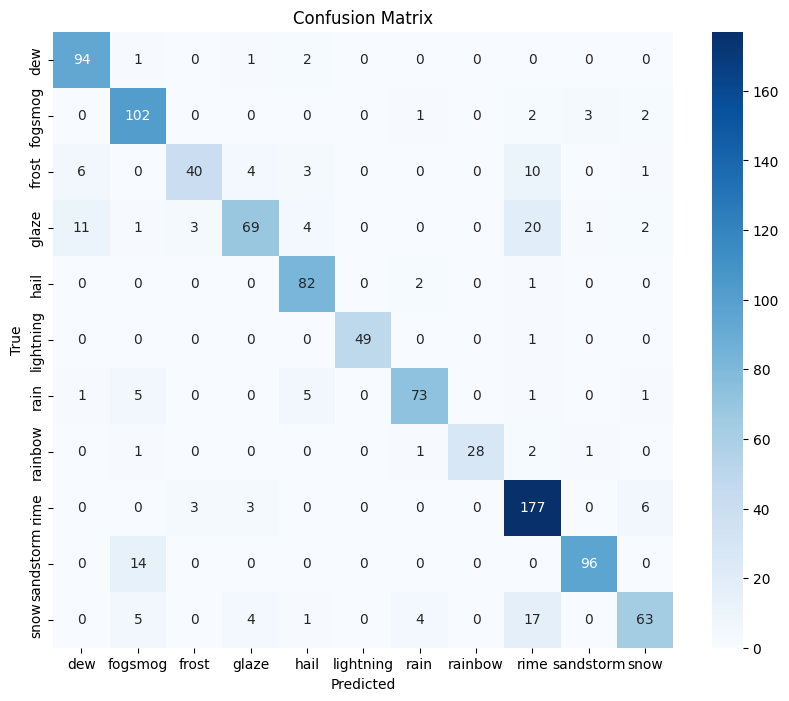

              precision    recall  f1-score   support

         dew       0.84      0.96      0.90        98
     fogsmog       0.79      0.93      0.85       110
       frost       0.87      0.62      0.73        64
       glaze       0.85      0.62      0.72       111
        hail       0.85      0.96      0.90        85
   lightning       1.00      0.98      0.99        50
        rain       0.90      0.85      0.87        86
     rainbow       1.00      0.85      0.92        33
        rime       0.77      0.94      0.84       189
   sandstorm       0.95      0.87      0.91       110
        snow       0.84      0.67      0.75        94

    accuracy                           0.85      1030
   macro avg       0.88      0.84      0.85      1030
weighted avg       0.85      0.85      0.84      1030



In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)

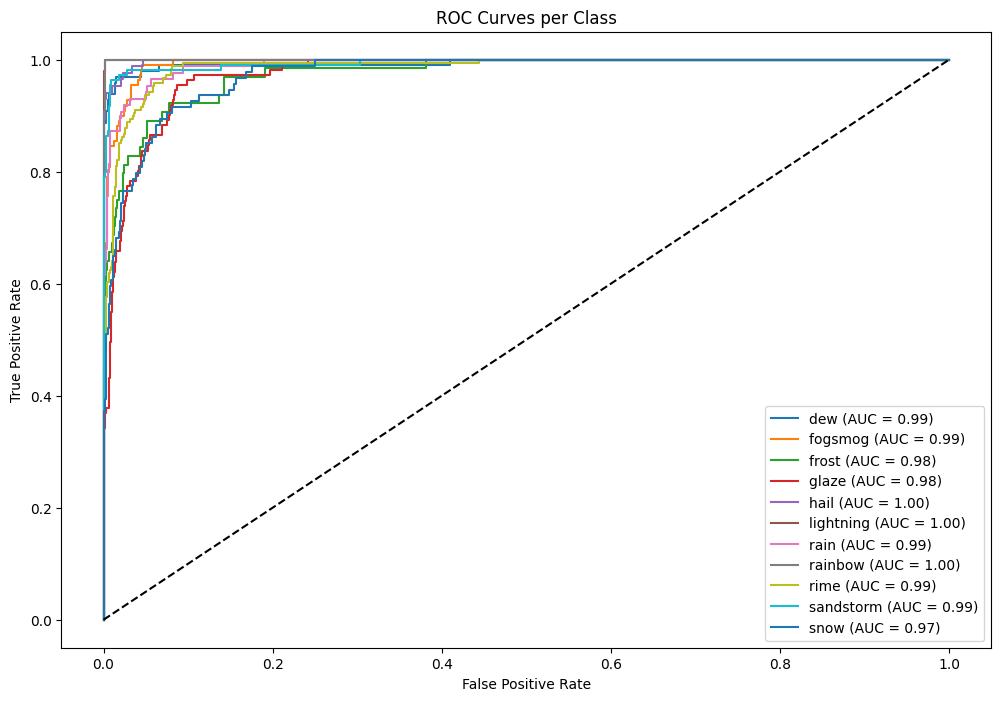

In [ ]:
plt.figure(figsize=(12,8))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Class")
plt.legend()
plt.show()

### Normalization

In [ ]:
from tensorflow.keras.layers import Rescaling
normalization_layer = Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
Validation_dataset = Validation_dataset.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
train_dataset_final = (train_dataset
                       .cache()
                       .shuffle(1000)
                       .prefetch(tf.data.AUTOTUNE)
                       )

validation_dataset_final = (Validation_dataset
                            .cache()
                            .prefetch(tf.data.AUTOTUNE)
                            )

### Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.4),
    tf.keras.layers.RandomTranslation(0.2,0.2),
    tf.keras.layers.RandomContrast(0.4),
    tf.keras.layers.RandomZoom(0.2)
    ])

### Helper Function

In [ ]:
def Calculate_Confusion_Matrix(y_true,y_pred,average='macro'):
    accuracy=np.mean( y_true == y_pred )
    precision=precision_score(y_true,y_pred,average=average,zero_division=0)
    recall=recall_score(y_true,y_pred,average=average,zero_division=0)
    f1=f1_score(y_true,y_pred,average=average,zero_division=0)
    return accuracy, precision, recall, f1

In [ ]:
def Plot_Confuision_Matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,  yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
def Plot_Loss_Accuracy_Curves(history):
    plt.plot(history['train_loss'],label='Training loss')
    plt.plot(history['val_loss'],label='Validation loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoches')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(history['train_acc'],label='Training Accuracy')
    plt.plot(history['val_acc'],label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoches')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
def Plot_Roc_Auc_Curve(y_true,y_score,class_names):
    y_true_bin=label_binarize(y_true,classes=range(len(class_names)))
    plt.figure(figsize=(8,6))
    for i, class_name in enumerate(class_names):
      fpr ,tpr , _ =roc_curve(y_true_bin[ :,i],y_score[:,i])
      roc_auc = auc(fpr, tpr)
      plt.plot(fpr,tpr ,label=f"{class_name}(Auc={roc_auc:.2f})")

    plt.plot([0,1],[0,1],'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [ ]:
def plot_loss_Accuracy_2(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()